## Import

In [1]:
#import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
#import data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
dataset = pd.concat([train,test])
dataset.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0.0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0.0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0.0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0.0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0.0,0,0,0,0,0


## Data Preprocessing

### Handling duplicates

In [3]:
#DUPLICATES
train.drop_duplicates(subset=train.columns.difference(['id']),inplace=True)
test.drop_duplicates(subset=test.columns.difference(['id']), inplace=True)

### Handling missing values

In [4]:
#MISSING VALUES
train.dropna(inplace=True)
test.dropna(inplace=True)

### Encode categorical features

In [5]:
#Searching for non-ordinal categorical features
categorical_columns = train.select_dtypes(include=['object']).columns.values
#Calculating unique values of categorical features
for col in categorical_columns:
    print(f" train {col}.unique = {len(train[col].unique())}, test {col}.unique = {len(test[col].unique())}") 

 train Product ID.unique = 9976, test Product ID.unique = 9909
 train Type.unique = 3, test Type.unique = 3


Since Product Id has too many unique values we cannot use one-hot encoding for this categorical feature because that will increase the dimesion of the feature space too much, resulting in slowing down the training time. Because of that we will use one-hot encoding for the Type feature and Frequency encoding for the ProductID feature (Some suggests to use Target enconding but I think that leads to overfitting)

In [6]:
#ONE-HOT ENCODING of Type column
for df in [train, test]:
    for value in df.Type.unique():
        df[f'Type{value}'] = 0
        df.loc[df.Type == f'{value}', f'Type{value}'] = 1
    df.drop(columns=['Type'], inplace=True)

In [7]:
#Frequency ENCODING of Product ID column (It is a way to utilize the frequency of the categories as labels)
for df in [train, test]:
    df['EncodedProductID'] = df.groupby(by=['Product ID'])['Product ID'].transform('count')
    df.drop(columns=['Product ID'], inplace=True)

## Feature engineering

In [8]:
def create_features(df):
    
    # Create a new feature by subtracting 'Air temperature' from 'Process temperature'
    # df['Temperature difference [K]'] = df['Process temperature [K]'] - df['Air temperature [K]']
    
    # Create a new feature by divided 'Air temperature' from 'Process temperature'
    df["Temperature ratio"] = df['Process temperature [K]'] / df['Air temperature [K]']
    
    # Create a new feature by multiplying 'Torque' and 'Rotational speed' (POWER)
    df['Torque * Rotational speed'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    # Create a new feature by multiplying 'Torque' by 'Tool wear'
    df['Torque * Tool wear'] = df['Torque [Nm]'] * df['Tool wear [min]']

    # Create a new feature by adding 'Air temperature' and 'Process temperature'
    # df['Temperature sum [K]'] = df['Air temperature [K]'] + df['Process temperature [K]']
    
    # Create a new feature by multiplying 'Torque' by 'Rotational speed'
    df['Torque * Rotational speed'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    df['TotalFailures'] = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)

    df.drop(['RNF'], axis =1, inplace = True)
    
    return df

In [9]:
train = create_features(train)

## Model

In [10]:
train_X = train.drop(columns=['id', 'Machine failure']).reset_index(drop=True)
train_y = train['Machine failure'].reset_index(drop=True)
n_features = len(train_X.columns)

In [11]:
train_X.shape

(135295, 17)

In [12]:
# StandardScaler
sc = StandardScaler() # MinMaxScaler or StandardScaler
train_X = sc.fit_transform(train_X)

In [13]:
model = tf.keras.Sequential()

In [14]:

model.add(tf.keras.layers.InputLayer(input_shape=(n_features,)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                576       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4

In [15]:
#weighting the unbalanced target
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)))

c:\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=0         0
1         0
2         0
3         0
4         0
         ..
135290    0
135291    0
135292    0
135293    0
135294    0
Name: Machine failure, Length: 135295, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [17]:
history = model.fit(train_X, train_y, batch_size=256, epochs=1000, class_weight=class_weights, callbacks=[early_stopping], validation_split=0.25)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/1000
397/397 [==============================] - 2s 2ms/step - loss: 0.3782 - auc: 0.9090 - val_loss: 0.1462 - val_auc: 0.9491
Epoch 2/1000
397/397 [==============================] - 1s 2ms/step - loss: 0.2101 - auc: 0.9647 - val_loss: 0.1590 - val_auc: 0.9483
Epoch 3/1000
397/397 [==============================] - 1s 2ms/step - loss: 0.2164 - auc: 0.9602 - val_loss: 0.1502 - val_auc: 0.9473
Epoch 4/1000
397/397 [==============================] - 1s 2ms/step - loss: 0.1933 - auc: 0.9707 - val_loss: 0.1719 - val_auc: 0.9524
Epoch 5/1000
397/397 [==============================] - 1s 2ms/step - loss: 0.1994 - auc: 0.9670 - val_loss: 0.1625 - val_auc: 0.9474
Epoch 6/1000
397/397 [==============================] - 1s 2ms/step - loss: 0.1988 - auc: 0.9698 - val_loss: 0.1400 - val_auc: 0.9500
Epoch 7/1000
397/397 [==============================] - 1s

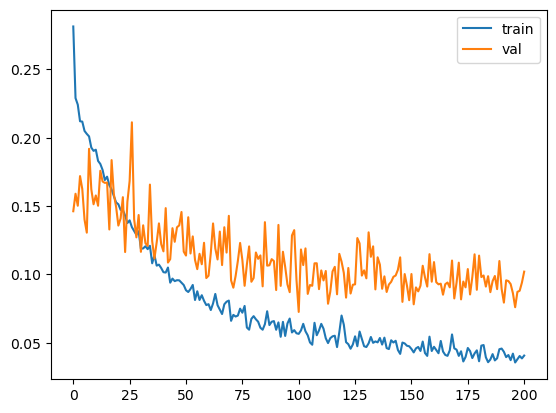

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()